## Visualizing the dataset
The dataset contains historical records on the change in the water level, x, and the amount of water flowing out of the dam, y. This dataset is divided into three parts:
* A training set that your model will learn on: *X, y*
* A cross validation set for determining the regularization parameter: _Xval, yval_
* A test set for evaluating performance. These are “unseen” examples which your model did not see during training: _Xtest, ytest_

In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = loadmat('./ex5/ex5data1.mat')
X = data['X']
y = data['y']
Xtest = data['Xtest']
ytest = data['ytest']
Xval = data['Xval']
yval = data['yval']

In [3]:
def plotData(X,y,title):
    plt.title(title)
    plt.scatter(X,y,marker='x',color='red')
    plt.xlabel('Change in water level(x)')
    plt.ylabel('Water flowing out of the dam(y)')

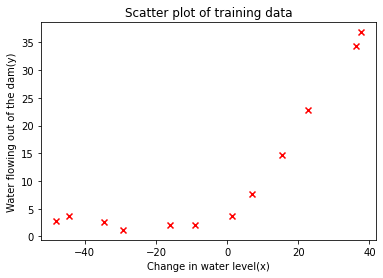

In [4]:
plotData(X,y,'Scatter plot of training data')
plt.show()

## Regularized linear regression cost function

In [5]:
def linearRegCostFunction(theta,X,y,_lambda):
    n = X.shape[0]
    hx = np.matmul(X,theta)
    J = 1/(2*n) * np.sum((hx-y)**2) + (_lambda/(2*n)) * np.sum(theta[1:]**2)
    return J

In [6]:
X_Bias = np.hstack((np.ones((X.shape[0],1)), X))
Xval_Bias = np.hstack((np.ones((Xval.shape[0],1)), Xval))
J = linearRegCostFunction(np.ones((X_Bias.shape[1],1)),X_Bias,y,1)
print("Cost using theta initialized at [1; 1]:",J)

Cost using theta initialized at [1; 1]: 303.9931922202643


## Regularized linear regression gradient

In [7]:
def gradient(theta,X,y,_lambda):
    n = X.shape[0]
    hx = np.matmul(X,theta)
    grad = (1/n) * np.matmul(X.T, hx - y) + (_lambda/n) * theta
    grad[0] = grad[0] - (_lambda/n) * theta[0]
    return grad

In [8]:
grad = gradient(np.ones((X_Bias.shape[1],1)),X_Bias,y,1)
print("Gradient using theta initialized at [1; 1]:",grad)

Gradient using theta initialized at [1; 1]: [[-15.30301567]
 [598.25074417]]


## Fitting linear regression
Here, we compute the optimal values of θ. Gradient Descent is used to optimize the cost function. In this part, we set regularization parameter λ to zero. Because our current implementation of linear regression is trying to fit a 2-dimensional θ, regularization will not be incredibly helpful for a θ of such low dimension.

In [9]:
def gradientDescentReg(theta,X,y,_lambda,learningRate,maxIterations):
    cost = np.zeros(maxIterations)
    for i in range(maxIterations):
        grad = gradient(theta,X,y,_lambda)
        theta = theta - learningRate*grad
        cost[i] = linearRegCostFunction(theta,X,y,_lambda)
    return theta,cost

In [10]:
learningRate = 0.002
maxIterations = 2000
theta, costs = gradientDescentReg(np.zeros((X_Bias.shape[1],1)),X_Bias,y,0,learningRate,maxIterations)

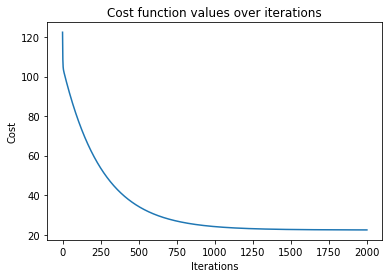

In [11]:
# Cost Function Trend
plt.plot(np.arange(maxIterations),costs)
plt.title('Cost function values over iterations')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

### Plotting the best fit line
Here, we plot the best fit line. The best fit line tells us that the model is not a good fit to the data because the data has a non-linear pattern.

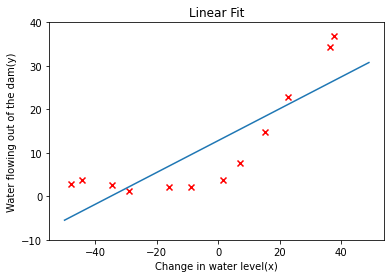

In [12]:
xPoints = [x for x in range(-50,50)]
yPoints = [theta[1]*x + theta[0] for x in xPoints]
plotData(X,y,'Linear Fit')
plt.plot(xPoints,yPoints)
plt.ylim(-10, 40) 
plt.show()

## Learning Curves
A learning curve plots training and cross validation error as a function of training set size. To plot a learning curve, we need a training and cross validation set error for different training set sizes. To obtain different training set sizes, we use different subsets of the original training set X. Specifically, for a training set size of i, we use the first i examples (i.e., X(1:i,:) and y(1:i)). After learning the θ parameters, we compute the error on the training and cross validation sets. 

Note: We set λ to 0 to exclude the regularization term.

In [13]:
def learningCurve(X,y,Xval,yval,_lambda):
    m,n = X.shape
    error_train = np.zeros(m)
    error_val = np.zeros(m)
    learningRate = 0.001
    maxIterations = 3500
    for i in range(m):
        theta, costs = gradientDescentReg(np.zeros((n,1)),X[0:i+1,:],y[0:i+1,:],_lambda,learningRate,maxIterations)
        error_train[i] = costs[-1]
        error_val[i] = linearRegCostFunction(theta,Xval,yval,_lambda)
    return error_train, error_val

In [14]:
error_train, error_val = learningCurve(X_Bias,y,Xval_Bias,yval,0)

In [15]:
def plotLearningCurve(x1,y1,x2,y2,title,xlabel,ylabel):
    plt.plot(x1,y1,label='Train')
    plt.plot(x2,y2,label='Cross Validation')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

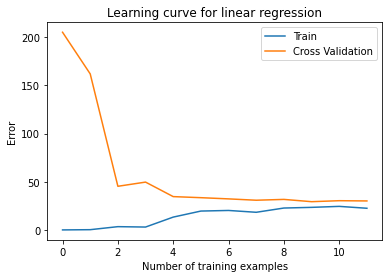

In [16]:
plotLearningCurve(np.arange(X.shape[0]),error_train,np.arange(X.shape[0]),error_val,'Learning curve for linear regression','Number of training examples','Error')

## Polynomial regression 
The problem with linear model was that it was too simple for the data and resulted in underfitting (high bias). Here, we will address this problem by adding more features. We add more features using the higher powers of the existing feature x in the dataset. In the X_poly matrix below, column 1 holds the original values of X, column 2 holds the values of X^2, column 3 holds the values of X^3, and so on.

In [17]:
def polyFeatures(X,p):
    for i in range(2,p+1):
        X = np.hstack((X,(X[:,0]**i)[:,np.newaxis]))
    return X

In [18]:
p = 8
X_poly = polyFeatures(X,p)
X_poly_test = polyFeatures(Xtest,p)
X_poly_val = polyFeatures(Xval,p)

## Learning Polynomial Regression 
We have used a polynomial of degree 8. Before learning the parameters θ for the polynomial regression, we normalize the features of the training set, storing the mu, sigma parameters separately. After learning the parameters θ, we plot the best fit curve and learning curve for polynomial regression with λ = 0.

In [19]:
def featureNormalize(X):
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X = (X - mu)/std
    return X,mu,std

In [20]:
X_poly,mu,std = featureNormalize(X_poly)
X_poly_1 =  np.hstack((np.ones((X_poly.shape[0],1)), X_poly))

X_poly_test = (X_poly_test - mu)/std
X_poly_test_1 = np.hstack((np.ones((X_poly_test.shape[0],1)), X_poly_test))

X_poly_val = (X_poly_val - mu)/std
X_poly_val_1 = np.hstack((np.ones((X_poly_val.shape[0],1)), X_poly_val))

theta, _ = gradientDescentReg(np.zeros((X_poly_1.shape[1],1)),X_poly_1,y,0,0.2,30000)

In [21]:
def polynomialFit(X,y,title,theta,mu,std,p):
    plotData(X,y,title)
    xPoints = np.linspace(-60,60,2500)
    xPoints_poly = polyFeatures(xPoints[:,np.newaxis], p)
    xPoints_poly = (xPoints_poly - mu)/std
    xPoints_poly = np.hstack((np.ones((xPoints_poly.shape[0],1)), xPoints_poly))
    yPoints_poly = xPoints_poly @ theta
    plt.plot(xPoints,yPoints_poly,"--")
    plt.show()

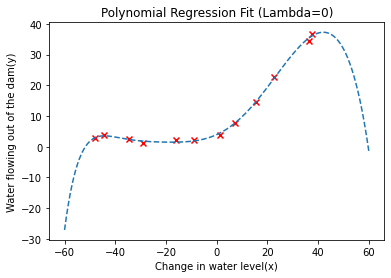

In [22]:
polynomialFit(X,y,'Polynomial Regression Fit (Lambda=0)',theta,mu,std,p)

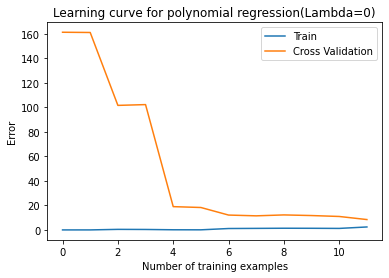

In [23]:
error_train, error_val = learningCurve(X_poly_1,y,X_poly_val_1,yval,0)
plotLearningCurve(np.arange(X.shape[0]),error_train,np.arange(X.shape[0]),error_val,'Learning curve for polynomial regression(Lambda=0)','Number of training examples','Error')

## Adjusting the regularization parameter
We modify the the lambda parameter and try λ = 1, 100. For each of these values, we generate a polynomial fit to the data and also a learning curve.

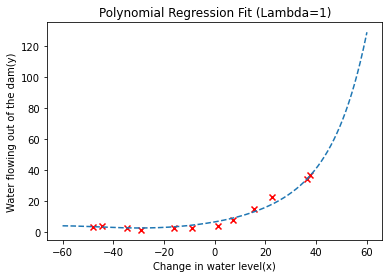

In [24]:
theta, _ = gradientDescentReg(np.zeros((X_poly_1.shape[1],1)),X_poly_1,y,1,0.2,30000)
polynomialFit(X,y,'Polynomial Regression Fit (Lambda=1)',theta,mu,std,p)

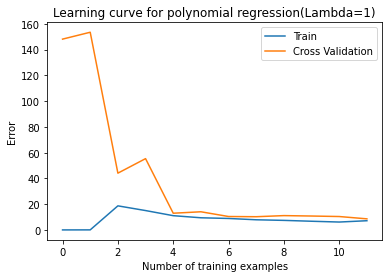

In [25]:
error_train, error_val = learningCurve(X_poly_1,y,X_poly_val_1,yval,1)
plotLearningCurve(np.arange(X.shape[0]),error_train,np.arange(X.shape[0]),error_val,'Learning curve for polynomial regression(Lambda=1)','Number of training examples','Error')

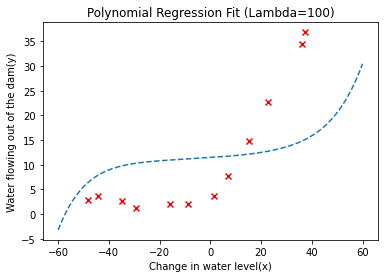

In [26]:
theta, _ = gradientDescentReg(np.zeros((X_poly_1.shape[1],1)),X_poly_1,y,100,0.1,20000)
polynomialFit(X,y,'Polynomial Regression Fit (Lambda=100)',theta,mu,std,p)

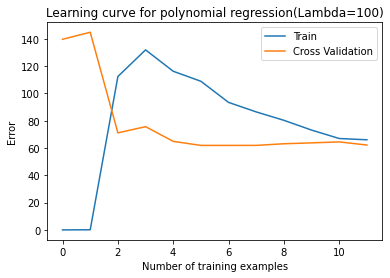

In [27]:
error_train, error_val = learningCurve(X_poly_1,y,X_poly_val_1,yval,100)
plotLearningCurve(np.arange(X.shape[0]),error_train,np.arange(X.shape[0]),error_val,'Learning curve for polynomial regression(Lambda=100)','Number of training examples','Error')

## Selecting λ using a cross validation set 
Previously we observed that the value of λ can significantly affect the results of regularized polynomial regression on the training and cross validation set. In particular, a model without regularization (λ = 0) fits the training set well, but does not generalize.  Conversely, a model with too much regularization (λ = 100) does not fit the training set and testing set well. A good choice of λ (e.g., λ = 1) can provide a good fit to the data. We train the model using different values of λ and compute the training error and cross validation error. We try λ in the following range: {0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10}. Finally, we plot a cross validation curve of error v.s. λ that allows us to select which λ parameter to use. 

In [28]:
def validationCurve(X, y, Xval, yval):
    lambda_vec = np.array([0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10])
    n = len(lambda_vec)
    error_train = np.zeros(n)
    error_val = np.zeros(n)
    for i in range(n):
        theta, costs = gradientDescentReg(np.zeros((X.shape[1],1)),X,y,lambda_vec[i],0.1,20000)
        error_train[i] = costs[-1]
        error_val[i] = linearRegCostFunction(theta,Xval,yval,lambda_vec[i])
    return  lambda_vec,error_train,error_val

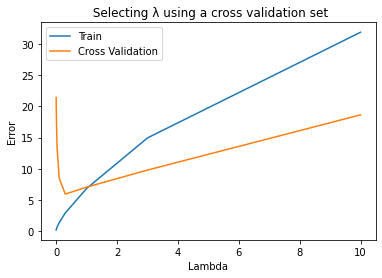

In [29]:
lambda_vec,error_train,error_val = validationCurve(X_poly_1,y,X_poly_val_1,yval)

plt.plot(lambda_vec,error_train,label='Train')
plt.plot(lambda_vec,error_val,label='Cross Validation')
plt.title(' Selecting λ using a cross validation set')
plt.xlabel('Lambda')
plt.ylabel('Error')
plt.legend()
plt.show()